In [1]:
import pandas as pd
import numpy as np
import spotipy
import seaborn as sns
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os


# NLTK Import for genres and text preprocessing
from collections import Counter
from nltk import word_tokenize

# Sklearn improvments
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Credentials & API authorization

In [2]:
# Credentials
client_id = '5746b79b7b2d49fd8e00c815bddf7be9'
client_secret = '2032da109bd8475792a4b924181b41f8'

# user_id = '5ynv6zmaqpztd1b5bwbqq4de6' # Vlad
user_id = '3v86yflxrdv7bndun1pst185b' # Kukuruzinka
# user_id = '608jfstr8bc3tgta3xjvoka8k' # Clarissa
# user_id = 'kvr4ilknbn5gly4ef08nilvnq' # Dimon
redirect_uri = 'http://localhost:5000/callback'
scope = "user-library-read"

In [3]:
# Two different ways of connecting to Spotify API (credentials & authorization)

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spot = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=scope))

In [4]:
# Creating subdirectory for plots 

path = str(sp.user(user_id)['display_name'])

try:
    os.mkdir(path)
except OSError:
    print("The directory with the name", path, "already exists")
else:
    print("Successfully created the directory %s " % path)

The directory with the name Nasty Nasti already exists


In [5]:
# Get playlist uris

def pl_ids(user_id):
    playlists = sp.user_playlists(user_id)
    pl_uris = []
    for x in playlists['items']:
        pl_uris.append(x['uri'])
    return pl_uris

uris = pl_ids(user_id)

In [6]:
# Get playlist tracks & features

def get_playlist_tracks(user, playlist_id):
    
    playlists_df = pd.DataFrame()
    
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results) # returns the next result given a paged result
        tracks.extend(results['items'])
    
    for x in tracks:
        if x['track'] is None:
            print('length before cleaning', len(tracks))
            tracks.remove(x)
            print('Length after cleaning', len(tracks))
        elif x['track']['id'] is None:
            print('length before cleaning', len(tracks))
            tracks.remove(x)
            print('Length after cleaning', len(tracks))
    
    for track in tracks:
        playlists_df['playlist_id'] = playlist_id
        playlists_df['track_id'] = np.array([x['track']['id'] for x in tracks]) # ToDo
        playlists_df['name'] = np.array([x['track']['name'] for x in tracks])
        playlists_df['artist'] = np.array([x['track']['album']['artists'][0]['name'] for x in tracks])
        playlists_df['artist_type'] = np.array([x['track']['album']['artists'][0]['type'] for x in tracks])
        playlists_df['artist_id'] = np.array([x['track']['album']['artists'][0]['id'] for x in tracks])
        playlists_df['album_type'] = np.array([x['track']['album']['album_type'] for x in tracks])
        playlists_df['added_at'] = np.array([x['added_at'] for x in tracks])
        playlists_df['duration_min'] = np.array([x['track']['duration_ms'] for x in tracks])
        playlists_df['duration_min'] = round(playlists_df['duration_min'] / 60000, 2)
        playlists_df['popularity'] = np.array([x['track']['popularity'] for x in tracks])
        
    return playlists_df

In [7]:
# Concatenating playlists
df = pd.DataFrame()
for x in uris:
    df = df.append(get_playlist_tracks(user=user_id, playlist_id=x), ignore_index=True)
    
df.tail()

length before cleaning 73
Length after cleaning 72
length before cleaning 72
Length after cleaning 71
length before cleaning 36
Length after cleaning 35


,playlist_id,track_id,name,artist,artist_type,artist_id,album_type,added_at,duration_min,popularity
1389,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,7pSFD2qZEhA0yjBjm2AU3Z,Ambivalence Waltz,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:14:19Z,2.50,15
1390,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,7u4iro506MSFKSVVHCdMfT,Lit from Underneath,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:15:04Z,3.26,25
1391,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3sI417Gx0Re5piE1Opqi2H,The Water Jet Cilice,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:15:47Z,3.90,17
1392,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3RQoKNylLrlbYNdThWNrg9,Fitz And The Dizzy Spells,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-16T07:17:53Z,3.61,0
1393,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3ME14528090NPLjcoppgaX,Solar Waltz,Cosmo Sheldrake,artist,6hV6oxGLeLFw17DGjIPkYD,album,2020-07-13T10:21:07Z,5.64,42


In [8]:
# Splitting ids to use audio_features 

track_ids = list(df['track_id']) 
track_ids = [track_ids[i:i+ 100] for i in range(0, len(track_ids), 100)] 
ft_list = []

for l in track_ids:
    features = sp.audio_features(l)
    
    for item in features:
        ft_list.append(item)

# Check None values in list of dict (sometimes spotify doesn't have audio features for some kind of tracks)
indices = [i for i in range(len(ft_list)) if ft_list[i] == None]
print('None on: ', indices)
print('Relative None: ', round(((len(indices)/len(ft_list)) * 100), 4), ' %')
        
# Replacing None values with mean values
ft_list[0]

mean_dict = {'danceability': 0,
 'energy': 0,
 'key': 0,
 'loudness': 0,
 'mode': 0,
 'speechiness': 0,
 'acousticness': 0,
 'instrumentalness': 0,
 'liveness': 0,
 'valence': 0,
 'tempo': 0,
 'type': 'audio_features',
 'id': 'None',
 'uri': 'None',
 'track_href': 'None',
 'analysis_url': 'None',
 'duration_ms': 0,
 'time_signature': 0}

ft_list = [mean_dict if i is None else i for i in ft_list]      

None on:  []
Relative None:  0.0  %


In [9]:
# Merge df's
features_df = pd.DataFrame(ft_list)

features_df = features_df.rename(columns={'id': 'track_id'}).drop(['uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'type'], axis =1)

In [10]:
df = df.merge(features_df, on='track_id')

In [11]:
df.tail()

,playlist_id,track_id,name,artist,artist_type,artist_id,album_type,added_at,duration_min,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1595,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,7pSFD2qZEhA0yjBjm2AU3Z,Ambivalence Waltz,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:14:19Z,2.50,15,...,0.192,2,-11.460,1,0.0331,0.934,0.000008,0.0834,0.238,86.607
1596,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,7u4iro506MSFKSVVHCdMfT,Lit from Underneath,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:15:04Z,3.26,25,...,0.151,0,-13.802,1,0.0373,0.916,0.947000,0.1090,0.615,108.610
1597,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3sI417Gx0Re5piE1Opqi2H,The Water Jet Cilice,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-02T05:15:47Z,3.90,17,...,0.252,2,-10.853,0,0.0377,0.986,0.809000,0.3580,0.562,113.566
1598,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3RQoKNylLrlbYNdThWNrg9,Fitz And The Dizzy Spells,Andrew Bird,artist,4uSftVc3FPWe6RJuMZNEe9,album,2019-10-16T07:17:53Z,3.61,0,...,0.766,9,-7.426,1,0.0371,0.410,0.001730,0.1100,0.681,134.090
1599,spotify:playlist:25mYM8SiPoxLhfoCkDAaOw,3ME14528090NPLjcoppgaX,Solar Waltz,Cosmo Sheldrake,artist,6hV6oxGLeLFw17DGjIPkYD,album,2020-07-13T10:21:07Z,5.64,42,...,0.243,10,-11.675,0,0.0277,0.715,0.077900,0.2890,0.257,112.676


In [12]:
# Retrieving genres (TAKES LONG BOOST UP IF POSSIBLE)
df['genres'] = df['artist_id'].apply(lambda x: sp.artist(x)['genres'])

# Data Visualization

Plotting different data features, distribtions, correlations and features development over time (annualy)

d:\apps\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


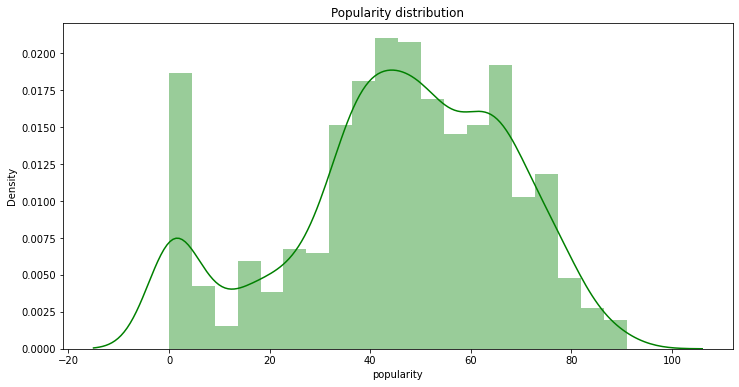

In [13]:
# Popularity distribution

plt.figure(figsize=(12, 6))
sns.distplot(df.popularity, bins=20, hist=True, color='g')
plt.title('Popularity distribution')
plt.savefig('{path}/popularity distribution'.format(path=path))

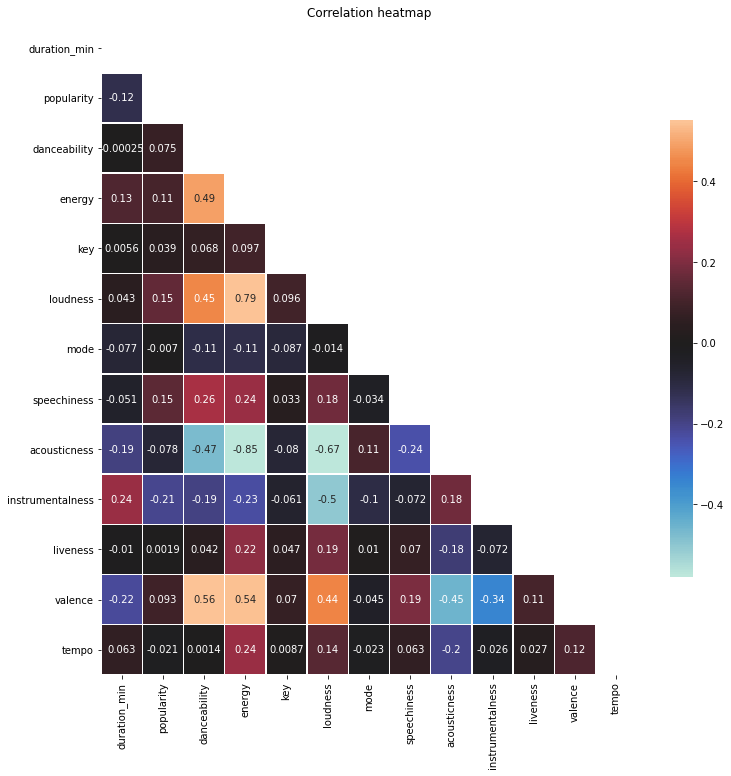

In [14]:
# Correlation map
plt.figure(figsize=(12,12))
df_hm = df.corr()

mask = np.triu(np.ones_like(df_hm, dtype=bool))

sns.heatmap(df_hm, annot=True, robust=True, mask=mask, center=0, linewidths=0.5, cbar_kws={"shrink": .7})
plt.title('Correlation heatmap')
plt.savefig('{path}/heatmap'.format(path=path))

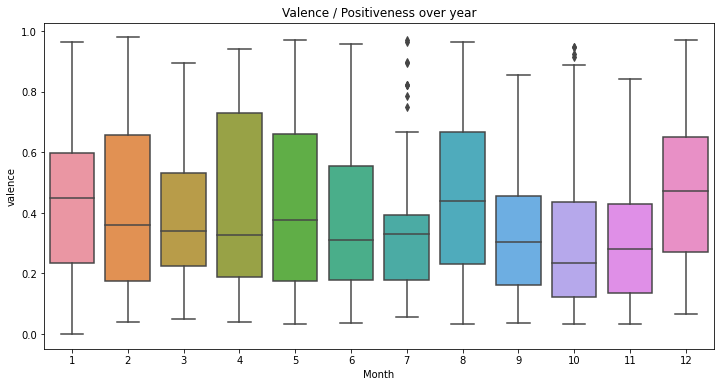

In [15]:
# Acousticness and instrumentalness by time
df['added_at'] = pd.to_datetime(df['added_at'], utc=False)

plt.figure(figsize=(12,6))
sns.boxplot(x=df.added_at.dt.month, y=df.valence)
plt.title('Valence / Positiveness over year')
plt.xlabel('Month')
plt.savefig('{path}/valence_positiveness'.format(path=path))

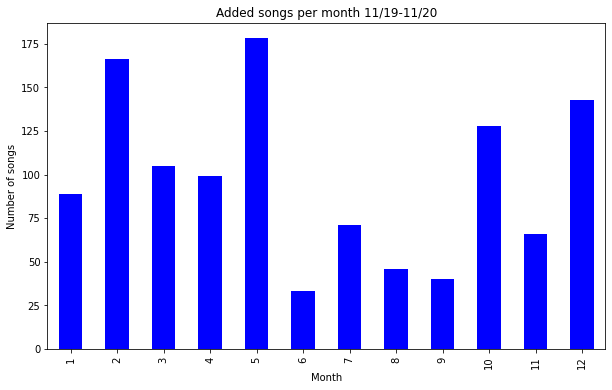

In [16]:
# Number of added songs by month 

addtimes = df[df['added_at'] >= '2019-11-11'].added_at.dt.month.value_counts(sort=False)

plt.figure(figsize=(10,6))
addtimes.plot.bar(color='blue')

plt.xlabel('Month')
plt.title('Added songs per month 11/19-11/20')
plt.ylabel('Number of songs')
plt.savefig('{path}/annual_added_songs'.format(path=path))

Top 5 songs with highest bpm: 
         tempo       name
1114  217.976    Opening
1113  217.976    Opening
1115  217.976    Opening
1116  217.976    Opening
1497  214.041  Moonbeams


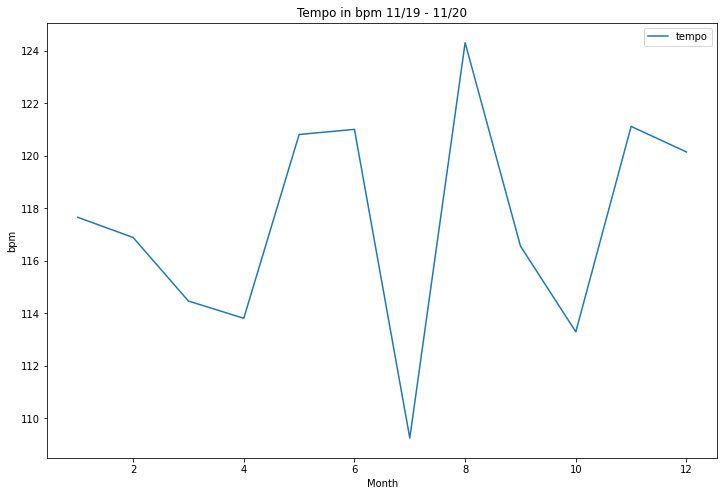

In [17]:
# Analysing tempo development by time 

top10_bpm = df.sort_values(by='tempo', ascending=False).head(5)[['tempo', 'name']]
print('Top 5 songs with highest bpm: \n', top10_bpm)

plt.figure(figsize=(12, 8))
# columns = ["acousticness","danceability","energy","speechiness","liveness","valence"]
columns = ['tempo']
for col in columns:
    x = df[df['added_at'] >= '2019-11-11'].groupby(df.added_at.dt.month)[col].mean()
    ax= sns.lineplot(x=x.index,y=x,label=col)
ax.set_title('Tempo in bpm 11/19 - 11/20')
ax.set_ylabel('bpm')
ax.set_xlabel('Month')
ax.legend()
plt.savefig('{path}/annual_tempo_dev'.format(path=path))

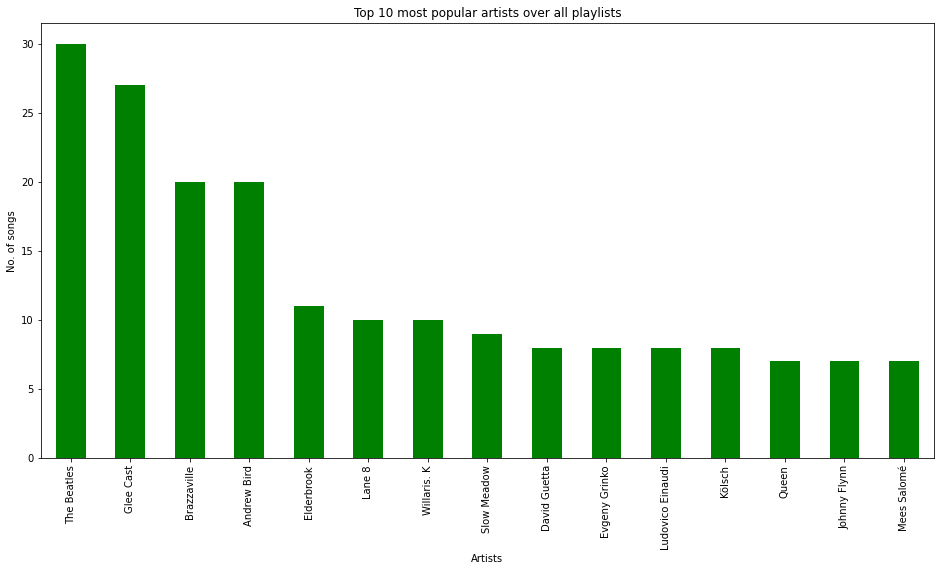

In [18]:
# Top 10 popular artists/bands & their distribution
top10_artist = df.groupby('artist')['track_id'].nunique().sort_values(ascending=False)

if 'Various Artists' in top10_artist:
    top10_artist = top10_artist.drop('Various Artists')

top10_artist.head(15)

plt.figure(figsize=(16,8))
top10_artist.head(15).plot.bar(color='green')
plt.title('Top 10 most popular artists over all playlists')
plt.ylabel('No. of songs')
plt.xlabel('Artists')
plt.savefig('{path}/top10_popular_artists'.format(path=path), bbox_inches='tight')

Relative empty genres:  10.75 %
('pop', 175)
('rock', 166)
('indie folk', 147)
('modern rock', 134)
('pop dance', 126)
('dance pop', 121)
('indie pop', 119)
('stomp and holler', 91)
('indie rock', 91)
('classic rock', 86)
('modern alternative rock', 71)
('tropical house', 69)
('post-teen pop', 67)
('compositional ambient', 64)
('pop rock', 59)


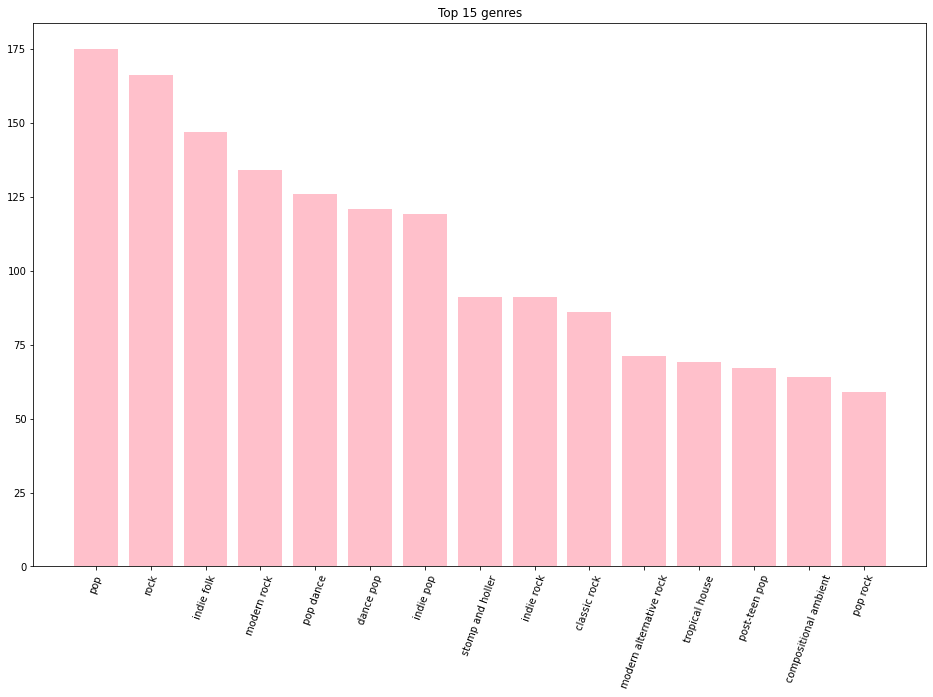

In [19]:
# Analysing genres
# Approach 1

empty_genres = df[df['genres'].str.len() == 0].genres.count().sum()
print('Relative empty genres: ', round(empty_genres * 100 / len(df), 3), '%')

genres_list = []
for x in df.genres:
    for sx in x:
        genres_list.append(sx)       

ctr = Counter(genres_list).most_common(15)
for x in ctr:
    print(x)
    
plt.figure(figsize=(16,10))
plt.bar(range(len(dict(ctr))), list(dict(ctr).values()), tick_label=list(dict(ctr).keys()), align='center', color='pink')
plt.xticks(rotation=70)
plt.title('Top 15 genres')
plt.savefig('{path}/top10_genres'.format(path=path), bbox_inches='tight')

In [20]:
# Approach 2 with tokenization
tokenized = []
for x in [word_tokenize(x) for x in genres_list]:
    for sx in x:
        tokenized.append(sx)

ctr1 = Counter(tokenized).most_common(15)
for x in ctr1:
    print(x)

('pop', 1283)
('rock', 1040)
('indie', 737)
('dance', 308)
('folk', 302)
('house', 284)
('modern', 252)
('alternative', 158)
('classic', 120)
('new', 106)
('ambient', 102)
('stomp', 95)
('french', 94)
('and', 93)
('rap', 92)


C         223
C♯, D♭    142
D         168
D♯, E♭     89
E         105
F         167
F♯, G♭     90
G         154
G♯, A♭    107
A         118
A♯, B♭    108
B         129
Name: key, dtype: int64


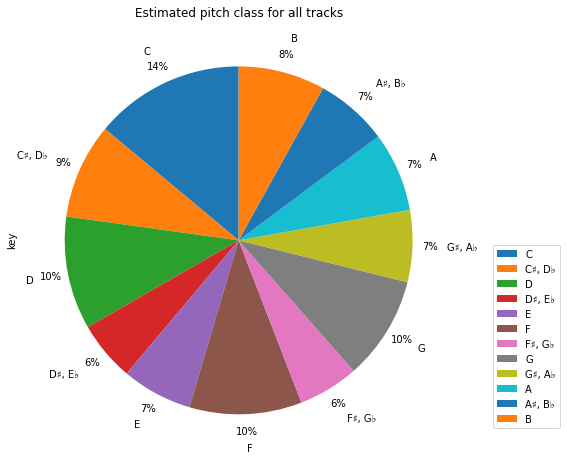

In [21]:
# Keys analysis

pitch_notation = {0:'C', 1:'C♯, D♭', 2:'D', 3:'D♯, E♭', 4:'E', 5:'F', 6:'F♯, G♭', 7:'G', 8:'G♯, A♭', 9:'A', 10:'A♯, B♭', 11:'B'}

kv = df.key.value_counts().sort_index(ascending=True).rename(pitch_notation)
print(kv)
plt.figure(figsize=(10,8))
kv.plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, startangle=90)
plt.title('Estimated pitch class for all tracks')
plt.colorbar
plt.legend(bbox_to_anchor=(0.75, 0., 0.5, 0.5))
plt.savefig('{path}/pitch_class_distribution'.format(path=path))
plt.show()

d:\apps\python\lib\site-packages\seaborn\distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


 Slope:  -1.1890310592152031 
 Intercept:  1.0464383927606897


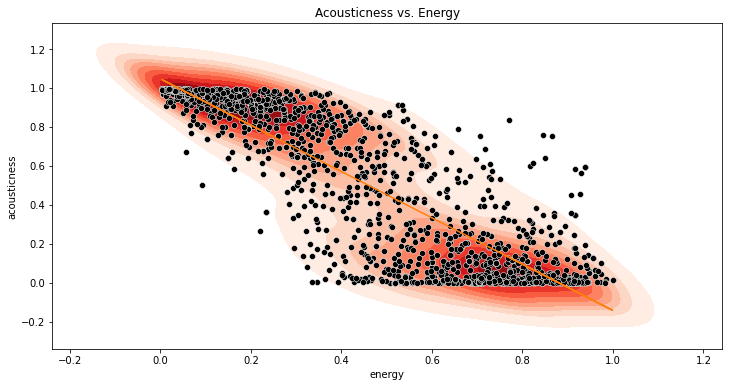

In [22]:
# Energy & Acousticness in scatter plot + regression + Kernel Density Estimation (KDE)
plt.figure(figsize=(12,6))

x = df.energy
y=df.acousticness

sns.kdeplot(y=y, x=x, shade=True, cmap='Reds', shade_lowest=False)
sns.scatterplot(y=y, x=x, color='black')

# Regression line --> Polyfit for extracting scale and 
k,b = np.polyfit(x,y, deg=1)
print(' Slope: ', k, '\n', 'Intercept: ', b)
plt.plot(x, k*x+b)

plt.title('Acousticness vs. Energy')
plt.savefig('{path}/acousticness_energy'.format(path=path))

 Number minor:  587 
 Number major:  1013


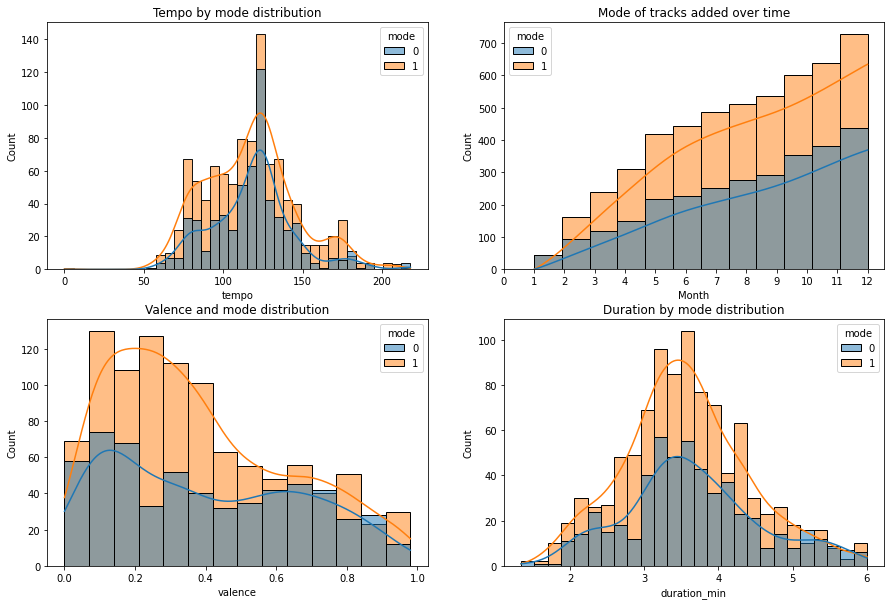

In [23]:
# Major minor distribution (mode)

minor = df.loc[df['mode'] == 0]
major = df.loc[df['mode'] == 1]

print(' Number minor: ', minor['mode'].count(), '\n', 'Number major: ', major['mode'].count())

# sns.histplot(minor.tempo, kde=True, cumulative=True, color='purple', label='Minor')
# sns.histplot(major.tempo, kde=True, cumulative=True, color='red', label='Major')

fig, ax = plt.subplots(2,2, figsize=(15,10), sharey=False)

sns.histplot(data=df, x='tempo', hue='mode', kde=True, legend=True, element='bars', ax=ax[0,0])
ax[0,0].set_title('Tempo by mode distribution')

pure_year = df[df['added_at'] >= '2019-11-11'].added_at.dt.month
sns.histplot(data=df, x=pure_year, hue='mode', kde=True, bins=12, cumulative=True, legend=True, element='bars', ax=ax[0,1])
ax[0,1].set_title('Mode of tracks added over time')
ax[0,1].set_xlabel('Month')
ax[0,1].set_xticks(range(13))

sns.histplot(data=df, x='valence', hue='mode', kde=True, legend=True, element='bars', ax=ax[1,0])
ax[1,0].set_title('Valence and mode distribution')



# Remove outliers from duration --> big influence on distribution visualiation
Q1 = df.duration_min.quantile(0.25)
Q3 = df.duration_min.quantile(0.75)
IQR = Q3- Q1
df_iqr = df[(df['duration_min'] >= (Q1 - 1.5 * IQR)) & (df['duration_min'] <= (Q3 + 1.5 * IQR))]


sns.histplot(data=df_iqr, x='duration_min', hue='mode', kde=True, ax=ax[1,1])
ax[1,1].set_title('Duration by mode distribution')

plt.savefig('{path}/mode_analysis'.format(path=path))
plt.show()

# Machine Learning. K-Means Analysis. Clustering algorithm. Visulaization.

1. Data Standartisation, because spreads in data can be different (x-axis: 1.9-1.3 = 0.6, y-axis: 80-20 = 60). 
Main idea: Standartisation of μ=0 (mean) and σ=1. Values of mean are super close to zero (due to numerical limitations)


Standard Deviation: σ = sqr(Sum(xi-μ)^2/N)

Mathematical representation of standartisation with scaler.StandardScaler():
Xis = (xi-μ)/σ

2. Choosing approx. number of k values, Elbow method and k-Means++ for determening number of k. Choose the most gentle change of the elbow curve (4 to 5) 

3. Dimension reduction. As we have 5 features (1 feature/column = 1 dimension) we can't plot them in 3D. Needed: 5D. Technique for dimension reduction by Principal component analysis (PCA)


 Transformed and scaled array's shape: (1600, 5)


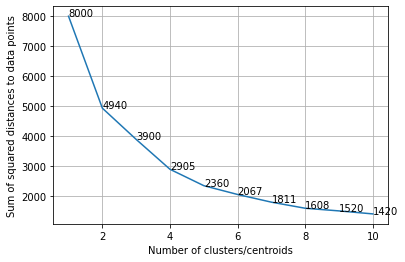

In [41]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness']

# Step 1.
df_cl = df[cluster_features]
X = np.array(df_cl)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print('\n Transformed and scaled array\'s shape:', X.shape)

# Step 2.
ss_dict = []
K = range(1, 11) # Approx. number of clusters
for k in K:
    km_test = KMeans(n_clusters=k, init='k-means++', random_state=123)
    km_test.fit(X)
    centers = km_test.cluster_centers_
    ss_dict.append(km_test.inertia_) # Returns sum of squared distances to the closet centroid k    

plt.plot(K, ss_dict)
plt.xlabel('Number of clusters/centroids')
plt.ylabel('Sum of squared distances to data points')
plt.grid()

for o,g in zip(K, ss_dict):
    plt.text(o, g, str(round(g)))

plt.show()

In [42]:
# Up to above graph choose value betwenn 4 and 6
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=123).fit(X)
km.cluster_centers_

array([[-0.92775909,  0.49124156, -0.08049451,  0.83706479, -0.09889687],
       [ 1.16165383, -1.07938245,  1.95169551, -1.20081603, -0.24647375],
       [ 0.81264423, -0.33483887, -0.49882274, -0.70181765, -0.35132105],
       [-0.71743299,  0.74886721, -0.4171421 ,  0.76873759,  3.25645299]])

# Principal Component Analysis

Dimensionality reduction for the visualization of multi-dimensional data

1. To reduce the dimensionality we use our transformed and scaled array X (μ = 0 and σ = 1)
2. Calculate cumulative and absolut explained variance
3. Plot how many % of explained variance is captured within Principal Components (PCs)
4. Explained variance ↑ --> information quality ↑
5. Choose the right number of PCs

Explained variance sum:  0.9999999999999999
Explained variance cummulative sum:  [0.48895777 0.67568174 0.84952703 0.97003932 1.        ]


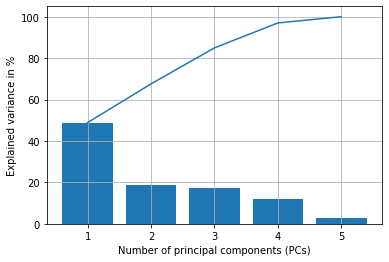

In [43]:
components = 5

pca = PCA(n_components=components, random_state=123)
pca_res = pca.fit_transform(X)

expl_var_cs = pca.explained_variance_ratio_.cumsum()
expl_var_s = pca.explained_variance_ratio_.sum()

print('Explained variance sum: ', expl_var_s)
print('Explained variance cummulative sum: ', expl_var_cs)

plt.plot(range(1, len(pca.components_)+1), expl_var_cs*100, label='cumulative')
plt.bar(range(1, len(pca.components_)+1), pca.explained_variance_ratio_*100, label='individual')
plt.plot()
plt.grid()
plt.xlabel('Number of principal components (PCs)')
plt.ylabel('Explained variance in %')
plt.xticks(range(1, components+1))
plt.show()

In [44]:
pca.explained_variance_

array([2.44631779, 0.93420374, 0.86977006, 0.60293826, 0.1498971 ])

In [45]:
# Create DataFrame with PCA results

df_pca = pd.DataFrame(pca_res)
df_pca.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
df_pca['cluster'] = km.labels_
df_pca.head(5)

,PC1,PC2,PC3,PC4,PC5,cluster
0,1.679403,0.192044,0.358265,0.919385,-0.068109,0
1,0.813916,2.051092,-0.498192,1.971416,0.099220,0
2,2.338547,0.351065,0.817763,-0.234156,0.006056,0
3,1.143538,-0.396900,-0.429248,-0.914262,0.550924,0
4,2.097216,-0.378117,-0.428076,-0.590915,0.059390,0


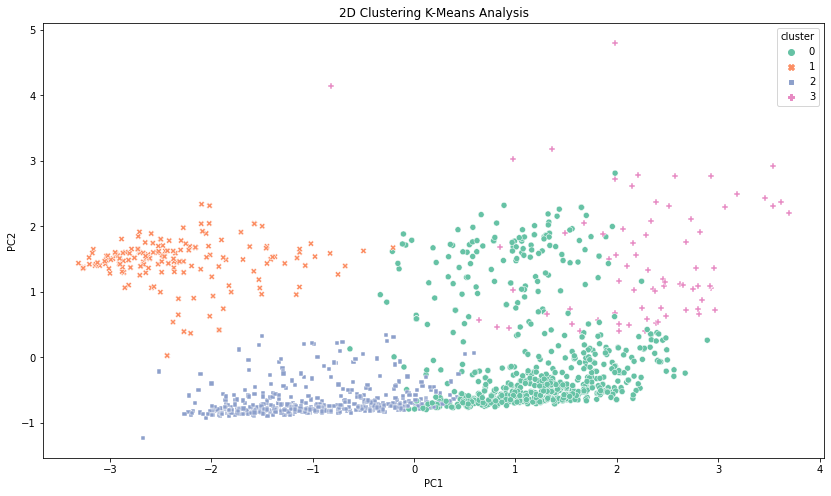

In [46]:
# Visualization of clusters on 2D plot

plt.figure(figsize=(14,8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', style='cluster', palette='Set2')
plt.savefig('5 PCs')
plt.title('2D Clustering K-Means Analysis')

plt.show()

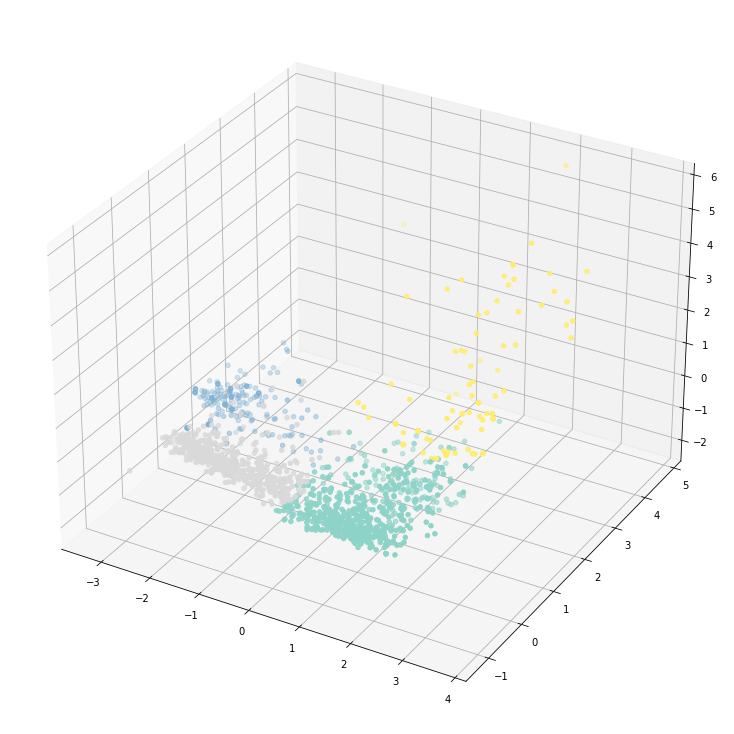

In [47]:
# Visualization of clusters on 3D plot

fig = plt.figure(figsize=(16,10))
ax = Axes3D(fig)

ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['cluster'], cmap='Set3')
plt.show()

# Song features distribution 

Comparing song features distributions (per cluster) with overall distributions to understand the principle of clustering songs

Total songs:  1600


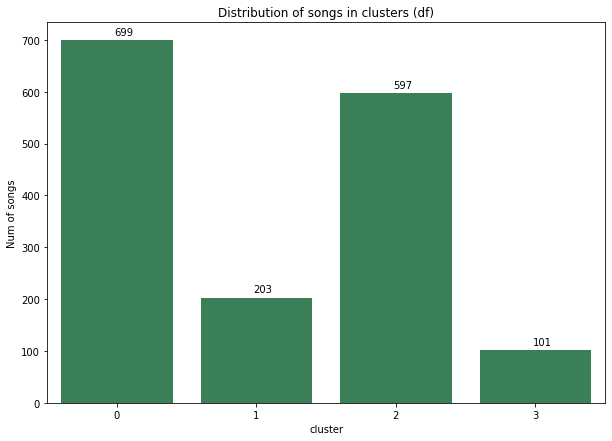

<Figure size 1152x576 with 0 Axes>

In [48]:
# Distribution of songs over clusters
df.loc[:, 'cluster'] = km.labels_
print('Total songs: ', df.track_id.count())
df_cluster_size = df.groupby('cluster').size().reset_index(name='Num of songs')


plt.figure(figsize=(10,7))
sns.barplot(data=df_cluster_size, x='cluster', y='Num of songs', color='seagreen')

for o, g in enumerate(df_cluster_size['Num of songs']):
    plt.text(o-0.02, g+10, str(g))
    
plt.title('Distribution of songs in clusters (df)')
plt.figure(figsize=(16,8))
plt.show()

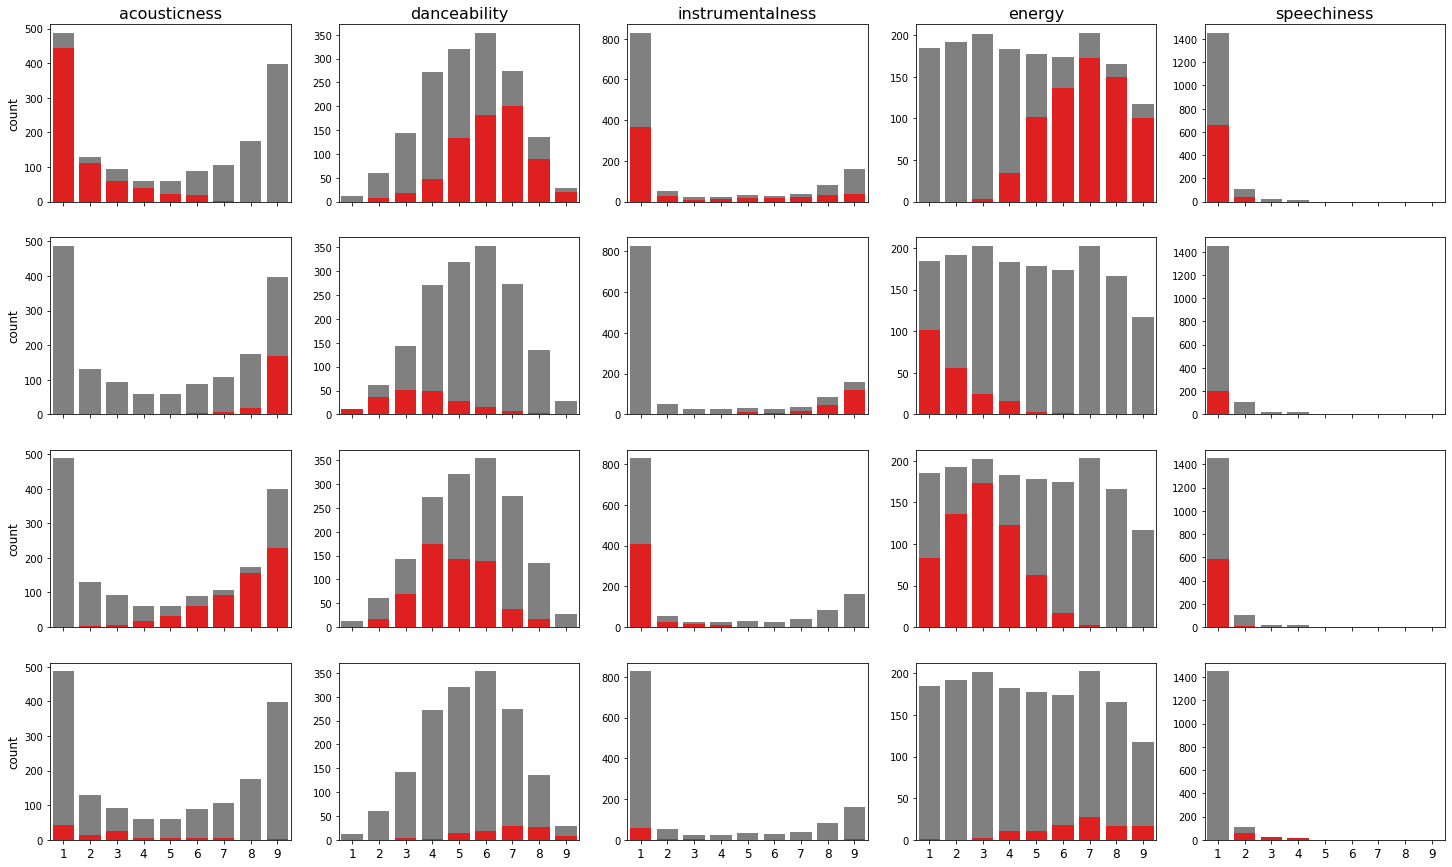

In [49]:
bins = np.linspace(0,1,10)

n_clusters = n_clusters
n_features = len(cluster_features)

f, axs = plt.subplots(n_clusters, n_features, figsize=(25,15), sharex='col')

row = 0
# Filtering by clusters (0 to 4)
for cl in np.sort(df.cluster.unique()):
    df_cluster = df[df['cluster'] == cl]
    col=0
    
    for ft in cluster_features:
        
        df_grouped = df.groupby(pd.cut(df[ft], bins)).size().reset_index(name='count')
        cluster_grouped = df_cluster.groupby(pd.cut(df_cluster[ft], bins)).size().reset_index(name='count')
        
        # plot overall distribution and cluster distribution on the ax
        sns.barplot(data=df_grouped, x=ft, y='count', 
                    color='grey', ax=axs[row, col])
        sns.barplot(data=cluster_grouped, x=ft, y='count', 
                    color='red', ax=axs[row, col])
        
        # configure axes
        axs[row, col].set_xlabel('')
        axs[row, col].set_xticklabels(range(1,10), fontsize=12)
        if col > 0:
            axs[row, col].set_ylabel('')
        else:
            axs[row, col].set_ylabel('count', fontsize=12)
        if row == 0:
            axs[row, col].set_title(ft, fontsize=16)        
        col += 1
    row += 1

plt.show()

In [50]:
# Mean values for every feature
raw_results = df.groupby('cluster').mean().reset_index()

In [51]:
sv = df.sort_values(by=['cluster'])[['cluster', 'genres']]

gg = []
gc=[]
i=0

while i<df.cluster.nunique():
    
    for x in sv[sv.cluster == i].genres:
        for sx in x:
            gg.append(sx) 
    
    ctr = Counter(gg).most_common(5)
    gg.clear() 
    gc.append([element[0] for element in ctr])
    i+=1
    
raw_results['genres_clustered'] = pd.Series(gc) # Converting list of lists to pd.Series and appending to the column
raw_results.genres_clustered.values

array([list(['rock', 'pop dance', 'pop', 'modern rock', 'dance pop']),
       list(['compositional ambient', 'neo-classical', 'indie folk', 'focus', 'soundtrack']),
       list(['indie folk', 'indie pop', 'stomp and holler', 'indie rock', 'pop']),
       list(['pop', 'dance pop', 'pop dance', 'pop rap', 'edm'])],
      dtype=object)

Text(0.5, 1.0, '2D Clustering K-Means Analysis')

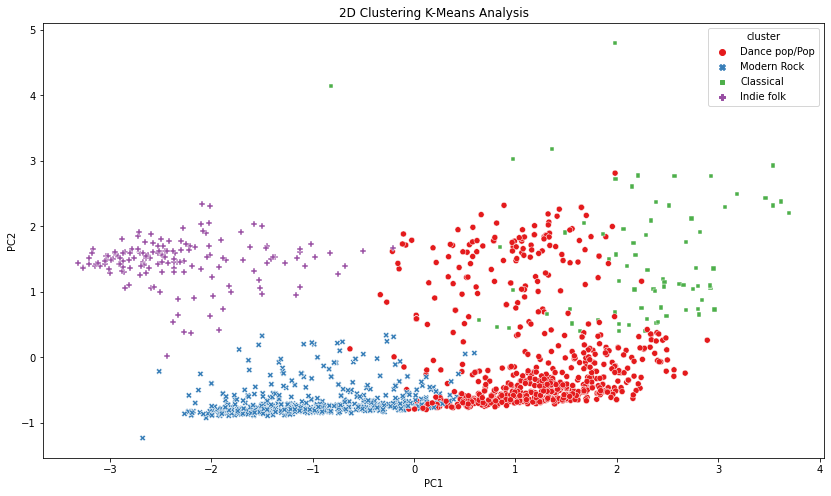

In [52]:
# Visualization by diff genres/clusters

df_pca['cluster'].replace({0:'Dance pop/Pop', 1:'Indie folk', 2:'Modern Rock', 3:'Classical', 4:'Indie'}, inplace=True)

plt.figure(figsize=(14,8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', style='cluster', palette='Set1')
plt.savefig('{path}/2D Clustering by genres'.format(path=path))
plt.title('2D Clustering K-Means Analysis')